# Lookback Put Options (with different Pricing Models)

Price a Lookback option using different models. Lookback options are valuable hedging tools for financial instruments that require the ability to capitalize on the best market prices over a specific period.  For a definition of the payoff, and the dataclass to construct a lookback put option timetable, see [lookback.py](./src/contracts/lookback.py)

In [1]:
import pandas as pd
from finmc.models.heston import HestonMC
from qablet.base.mc import MCPricer

from data.spx_2005_09_15 import basic_info, dataset
from src.contracts.lookback import lookback_put_timetable
from src.model.localvol import LVMC
from src.model.rbergomi import rBergomiMC

Contract:

Create a Lookback put option contract fixing time to maturity,T=0.2 with num of monitoring points,m=4

In [2]:
prc_dt = basic_info["prc_dt"]
ticker = basic_info["ticker"]

start_date = prc_dt
T = 0.2
num_points = 4

timetable = lookback_put_timetable(ticker, start_date, T, num_points)
print(timetable["events"].to_pandas())

                       time   op  quantity      unit track
0 2005-09-14 00:00:00+00:00  NaN       0.0      INIT      
1 2005-10-02 06:18:00+00:00  NaN       0.0    UPDATE      
2 2005-10-20 12:36:00+00:00  NaN       0.0    UPDATE      
3 2005-11-07 18:54:00+00:00  NaN       0.0    UPDATE      
4 2005-11-26 01:12:00+00:00    +       1.0  LOOKBACK      


Compare Models:

Compare different models, starting with Local Volatility Model.

In [3]:
models = {}

model = MCPricer(LVMC)
price, _ = model.price(timetable, dataset)
print(f"Localvol price: {price}")
models["Localvol"] = model

Localvol price: 34.00020686865014


Heston Model:

In [4]:
model = MCPricer(HestonMC)
price, _ = model.price(timetable, dataset)
print(f"Heston price: {price}")
models["Heston"] = model

Heston price: 35.12264081826051


Bergomi Model:

In [5]:
model = MCPricer(rBergomiMC)
price, _ = model.price(timetable, dataset)
print(f"rBergomi price: {price}")
models["rBergomi"] = model

rBergomi price: 31.228086154732303


Contract:

Create a series of Lookback put option contracts, with time to maturity, T=0.5 with num of monitoring points, m=[5,10,20,50,100].

In [6]:
ticker = "SPX"
start_date = prc_dt
T = 0.5

# List of various monitoring points to analyze
monitoring_points_list = [5, 10, 20, 50, 100]
timetables = []

for num_points in monitoring_points_list:
    timetable = lookback_put_timetable(ticker, start_date, T, num_points)
    timetables.append(timetable)

Run this series through each model.

In [7]:
df = pd.DataFrame({"m": monitoring_points_list})
for model_name, model in models.items():
    df[model_name] = [
        model.price(timetable, dataset)[0] for timetable in timetables
    ]
    print(f"{model_name} done")
    print(df)

Localvol done
     m   Localvol
0    5  59.379463
1   10  64.964001
2   20  69.227225
3   50  73.565489
4  100  75.604826
Heston done
     m   Localvol     Heston
0    5  59.379463  56.414852
1   10  64.964001  60.958050
2   20  69.227225  64.536904
3   50  73.565489  67.702643
4  100  75.604826  69.030882
rBergomi done
     m   Localvol     Heston   rBergomi
0    5  59.379463  56.414852  55.028070
1   10  64.964001  60.958050  59.181010
2   20  69.227225  64.536904  62.023965
3   50  73.565489  67.702643  64.262191
4  100  75.604826  69.030882  65.025618


## Plot

<Axes: title={'center': 'Lookback Put Prices'}, xlabel='m'>

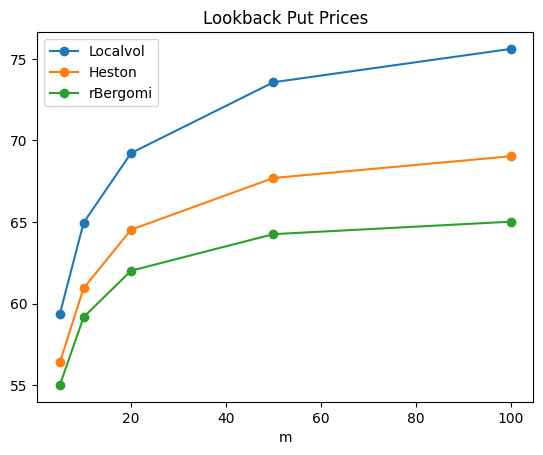

In [11]:
df.columns
df.plot(
    x="m",
    y=models.keys(),
    marker="o",
    title="Lookback Put Prices",
)